In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import pathlib as pathlib
import corner
from mcplots_himes import pairwise
from tabulate import tabulate

## Corner Plots: What are they?

Using random data, we can see the random data is not correlated. The covariance of the parameters is shown in the 
2D plots (which look like bullseyes) and the 1D plots are the histograms. The histograms show the distribution of the 
single parameter. So, you can see how the parameters interact with each other, and how distributed the data for one parameter is. 
The simple explanation for reading a corner plot is as follows: if the 2D plots look like a bullseye, that is a good thing. 
It means that the parameters are not influencing each other. If it is oblong, then there is a degeneracy between the parameters, 
i.e. there is a dependency. We'll see it more as we move along in this notebook.


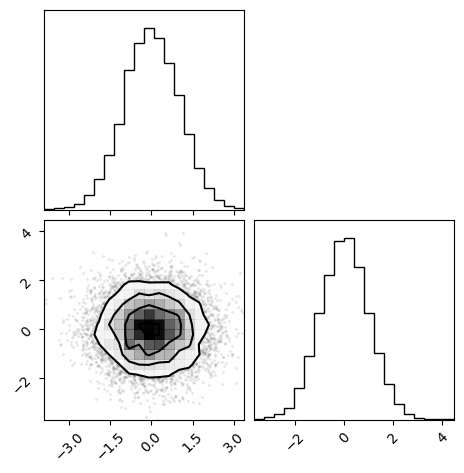

In [2]:
#Corner.corner example (https://corner.readthedocs.io/en/latest/pages/quickstart/)

#generate random data, using the seed function to make sure it's the same random data each time.
ndim, nsamples = 2, 10000
np.random.seed(42)

#draw from a standard normal distribution
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])

#create a corner plot of the data
figure = corner.corner(samples)


print("""Using random data, we can see the random data is not correlated. The covariance of the parameters is shown in the 
2D plots (which look like bullseyes) and the 1D plots are the histograms. The histograms show the distribution of the 
single parameter. So, you can see how the parameters interact with each other, and how distributed the data for one parameter is. 
The simple explanation for reading a corner plot is as follows: if the 2D plots look like a bullseye, that is a good thing. 
It means that the parameters are not influencing each other. If it is oblong, then there is a degeneracy between the parameters, 
i.e. there is a dependency. We'll see it more as we move along in this notebook.""")

Here is an example of a more complex corner plot. This time, the median value is shown per parameter atop the 1D plot (remember, that's the histogram!)
along with the upper and lower constraints (the sigma calculation done by the "quantiles" line in the corner.corner call). The quantiles calculate, in order, the 
16th percentile which is the lower bound of the 68 percent credible region, the 50th percentile which is the median, and the 84 percentile which is the upper bound 
of the 68 percent credible region. The 68% percent credible region is also what 1 sigma is! This allows you to see how well your data is constrained to the truth, and 
if it's retrieving outside of it, you can get an estimation as to what parameter is the problem. The only thing that missing from this corner plot are where the true 
values are per parameter. But, we have a problem here...


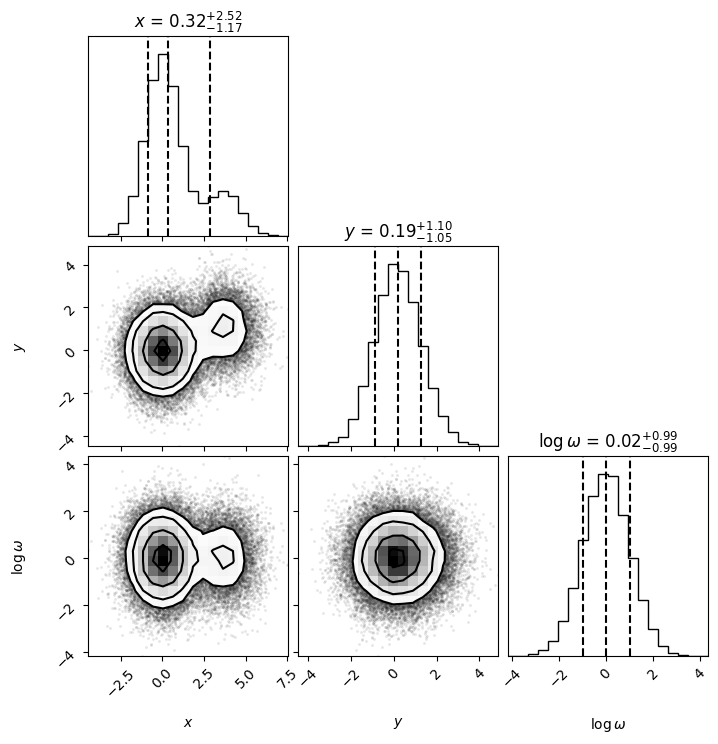

In [3]:
#Corner.corner example (https://corner.readthedocs.io/en/latest/pages/quickstart/)

# Set up the parameters of the problem.
ndim, nsamples = 3, 50000

# Generate some fake data.
np.random.seed(42)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape(
    [4 * nsamples // 5, ndim]
)
data2 = 4 * np.random.rand(ndim)[None, :] + np.random.randn(
    ndim * nsamples // 5
).reshape([nsamples // 5, ndim])
data = np.vstack([data1, data2])

# Plot it.
figure = corner.corner(
    data,
    labels=[
        r"$x$",
        r"$y$",
        r"$\log \omega$",
        r"$\Gamma \, [\mathrm{parsec}]$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

if not os.path.exists(f'./figures'):
    os.makedirs(f'./figures')
figure.savefig("./figures/corner_plot.png")

print("""Here is an example of a more complex corner plot. This time, the median value is shown per parameter atop the 1D plot (remember, that's the histogram!)
along with the upper and lower constraints (the sigma calculation done by the "quantiles" line in the corner.corner call). The quantiles calculate, in order, the 
16th percentile which is the lower bound of the 68 percent credible region, the 50th percentile which is the median, and the 84 percentile which is the upper bound 
of the 68 percent credible region. The 68% percent credible region is also what 1 sigma is! This allows you to see how well your data is constrained to the truth, and 
if it's retrieving outside of it, you can get an estimation as to what parameter is the problem. The only thing that missing from this corner plot are where the true 
values are per parameter. But, we have a problem here...""")

### So, here's the problem:

Corner.py doeosn't actually calculate the credible regions correctly - it takes maximum likliehood, and then calculates the uncertainty by doing an asymetric distrubition on either side of the liklihood. But, that means we can see obvious errors in certain cases. Let's look at the second case above again, and compare the corner.py plot to a different plotting method that calculates credible regions differently.

Here, we can see the difference between the panel on the left (what we saw before) and a more robust calculation using pairwise on the right. Pairwise calculates 
more than just the 68 percent credible region, but we're going to focus on just that for now. We can see that in the right corner plot, the 68 percent credible region is placed
differently than the left corner plot. That's because the left corner plot is being influenced by the additional bump in data to the right of the main data concentration. That's shifting
the credible region to the right, incorrectly. However, we can see that this same problem doesn't happen to the other gaussian fits - which shows you the danger of corner.py, 
because it's wrong in very specific instances that are critical! But, we're using random data so that's not super clear. So let's try an real example of real data and see what it looks like!


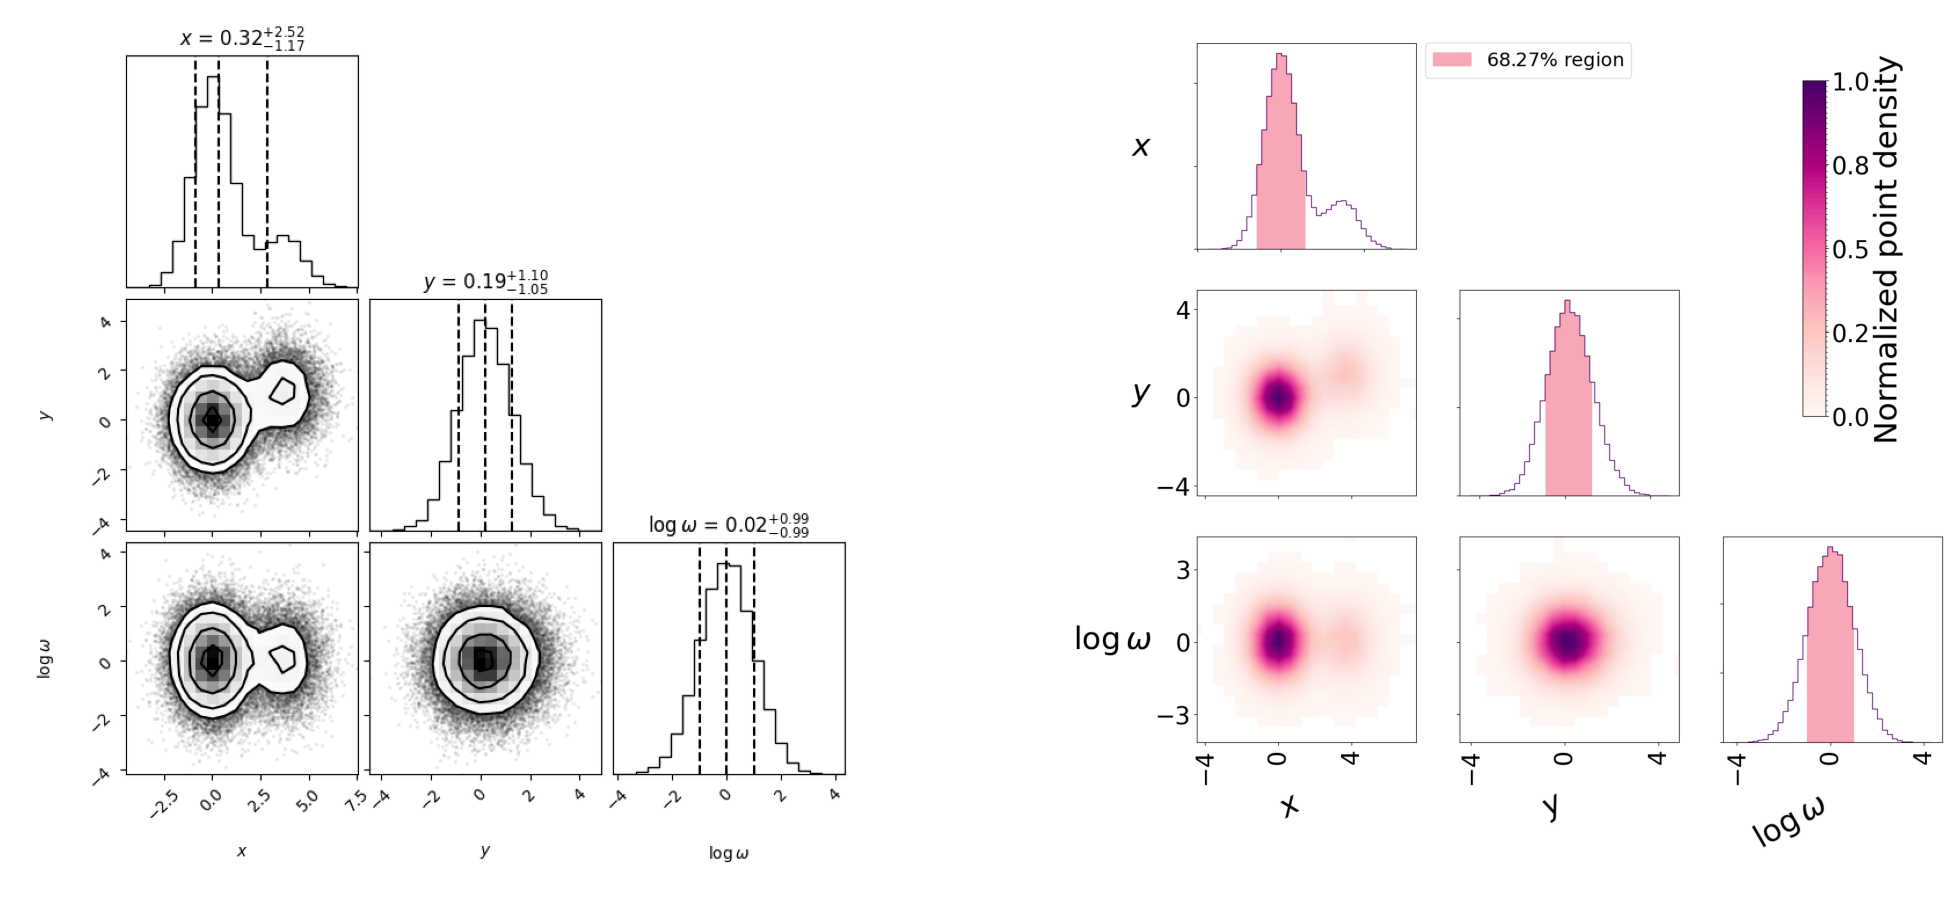

In [4]:
# Load and display the two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 25))

figure = pairwise(data.T, parname=["$x$", "$y$", "$\log \omega$"], thinning=1,
                        fignum=-11, savefile="./figures/pairwise_plot.png", style="hist", fs=36, nbins=20, truepars=None, credreg=True, ptitle=False, ndec=None)

# Display corner plot
corner_img = plt.imread("./figures/corner_plot.png")
ax1.imshow(corner_img)
ax1.axis("off")

# Display pairwise plot
pairwise_img = plt.imread("./figures/pairwise_plot.png")
ax2.imshow(pairwise_img)
ax2.axis("off")

print("""Here, we can see the difference between the panel on the left (what we saw before) and a more robust calculation using pairwise on the right. Pairwise calculates 
more than just the 68 percent credible region, but we're going to focus on just that for now. We can see that in the right corner plot, the 68 percent credible region is placed
differently than the left corner plot. That's because the left corner plot is being influenced by the additional bump in data to the right of the main data concentration. That's shifting
the credible region to the right, incorrectly. However, we can see that this same problem doesn't happen to the other gaussian fits - which shows you the danger of corner.py, 
because it's wrong in very specific instances that are critical! But, we're using random data so that's not super clear. So let's try an real example of real data and see what it looks like!""")
      
plt.show()

Here we can begin to see the effects of real data, and any degeneracies that exist between parameters! See for instance the 2D posterior between CH4 and cloud fraction Cf. It is clearly elongated, showing that there is a
degeneracy between the two parameters (which is expected from Cf!). What else do you see?


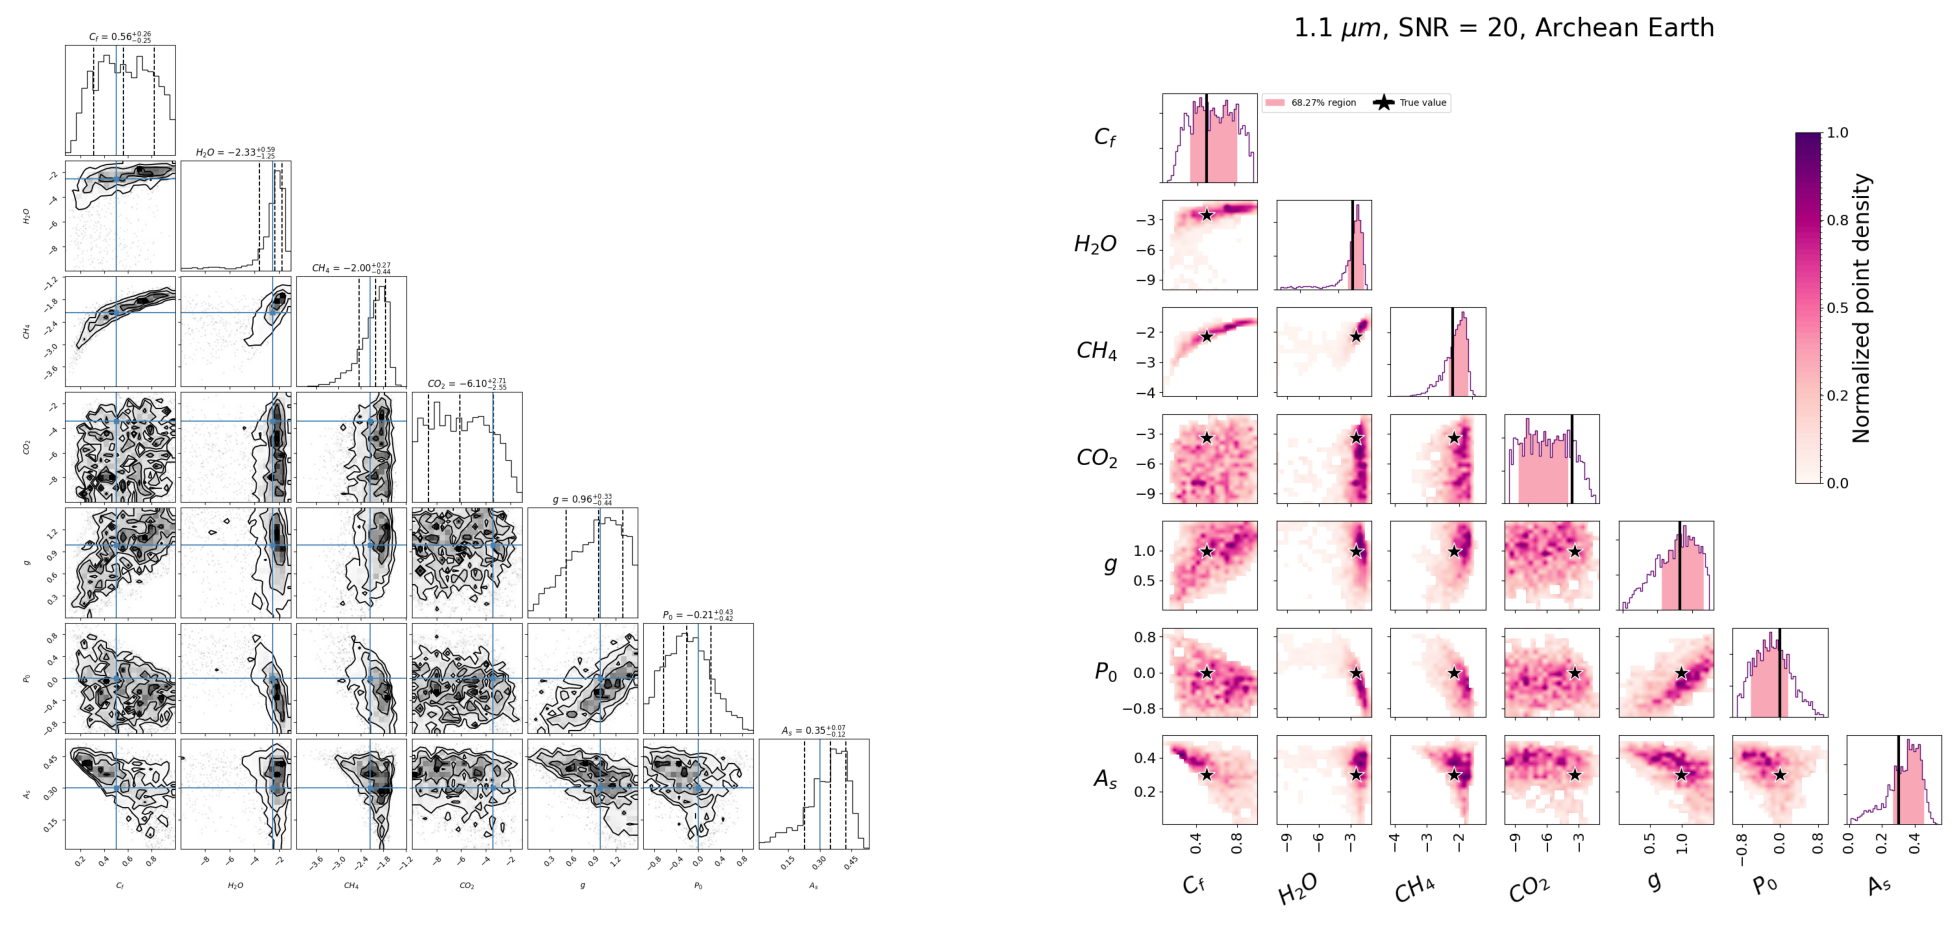

In [5]:
full_post1 = np.loadtxt(f"post_test.txt")
fullpost1 = np.transpose(full_post1)

cloud_f = 0.5
H2O = 3e-3
P0 = 1.0
CH4 = 7.07e-3 
CO2 = 3.8e-4
g = 9.8
As = 0.3
Rp = 1.0
true_vals = [0.5, np.log10(H2O), np.log10(CH4), np.log10(CO2), np.log10(g), np.log10(P0), As]

# Plot it.
figure = corner.corner(
    full_post1,
    labels=[
        r"$C_f$", 
        r"$H_2O$", 
        r"$CH_4$", 
        r"$CO_2$", 
        r"$g$", 
        r"$P_0$", 
        r"$A_s$",
    ],
    truths = true_vals,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
figure.savefig("./figures/corner_plot_real.png")
plt.close(figure)

figure1 = pairwise(fullpost1, title='1.1 $\mu m$, SNR = 20, Archean Earth', parname=["$C_f$", "$H_2O$", "$CH_4$", "$CO_2$", "$g$", "$P_0$", "$A_s$"], thinning=1, savefile="./figures/pairwise_plot_real.png",
             fignum=-11, style="hist", fs=24, nbins=20, truepars=true_vals, credreg=True, ptitle=False, ndec=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 25))
# Display corner plot
corner_img = plt.imread("./figures/corner_plot_real.png")
ax1.imshow(corner_img)
ax1.axis("off")

# Display pairwise plot
pairwise_img = plt.imread("./figures/pairwise_plot_real.png")
ax2.imshow(pairwise_img)
ax2.axis("off")

print("""Here we can begin to see the effects of real data, and any degeneracies that exist between parameters! See for instance the 2D posterior between CH4 and cloud fraction Cf. It is clearly elongated, showing that there is a
degeneracy between the two parameters (which is expected from Cf!). What else do you see?""")
      
plt.show()

# Single Example of a PSGnest run

Now, we're going to run through one single case example of a PSGnest run, to demonstrate what needs to happen to go from a config, to a retrieval, to a corner plot!

In [6]:
os.system(f"curl -d type=ret -d app=psgnest --data-urlencode file@PSGnest_config.txt https://psg.gsfc.nasa.gov/api.php > PSGnest_results.txt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  608k    0  606k  100  2116  36816    125  0:00:16  0:00:16 --:--:--  170k


0

In [7]:
# Open the PSGnest results file for reading
result = open("PSGnest_results.txt", "r")

# Define file paths for posteriors and evidences
post_file_name = f"post.txt"
evidence_file_name = f"evidence.txt"

# Remove existing posterior and evidence files if they exist
if os.path.exists(post_file_name):
    os.remove(post_file_name)
if os.path.exists(evidence_file_name):
    os.remove(evidence_file_name)

evidences = []  # List to store evidence values
loglikes = []  # List to store log-likelihood values

# Initialize variables for parsing the results
spectrum_start = 0
posterior_start = 0
posterior_end = 0
best_fit_spectrum = []  # List to store the best-fit spectrum
posteriors = []  # List to store posterior samples
line_index = 1
spectrum_retrieved = False
posterior_retrieved = False

# Loop through each line of the PSGnest results file
for line in result.readlines():
    # Check for keywords indicating the start of the spectrum or posterior sections
    if "results_dat" in line:
        spectrum_start = line_index
    if "results_nst" in line:
        posterior_start = line_index
    if "Computation time" in line:
        posterior_end = line_index

    line_index += 1

    # Retrieve the best-fit spectrum data between spectrum_start and posterior_start
    if spectrum_start != 0 and posterior_start != 0 and not spectrum_retrieved:
        result2 = open("PSGnest_results.txt", "r")
        for line2 in result2.readlines()[spectrum_start:posterior_start - 1]:
            try:
                best_fit_spectrum.append(float(line2.split()[-1]))  # Append spectrum value
            except ValueError:
                continue  # Skip lines that don't contain valid floats

        result2.close()
        spectrum_retrieved = True

    # Retrieve posterior samples and log-likelihood values
    if posterior_start != 0 and posterior_end != 0 and not posterior_retrieved:
        result2 = open("PSGnest_results.txt", "r")
        for line2 in result2.readlines()[posterior_start:posterior_end - 1]:
            posterior_sample = [float(i) for i in line2.split()[:-1]]  # Parse the posterior sample
            posteriors.append(posterior_sample)
            loglike = float(line2.split()[-1])  # Extract log-likelihood value
            loglikes.append(loglike)

        result2.close()

        posterior_retrieved = True
    # If the line contains the log-evidence, save it in the evidence file
    
    if "Nested Sampling Global Log-Evidence" in line:
        with open(evidence_file_name, "w") as f:  # Overwrite the evidence file
            f.write(line.split()[-1])  # Write the log-evidence value

result.close()
# Convert the posteriors list to a NumPy array
posteriors = np.array(posteriors)
# Write the posterior samples to the post.txt file

with open(post_file_name, "w") as f:
    for i in posteriors:
        f.write(str(i[0])+" "+str(i[1])+" "+str(i[2])+" "+str(i[3])+" "+str(i[4])+" "+str(i[5])+" "+str(i[6])+" "+"\n")

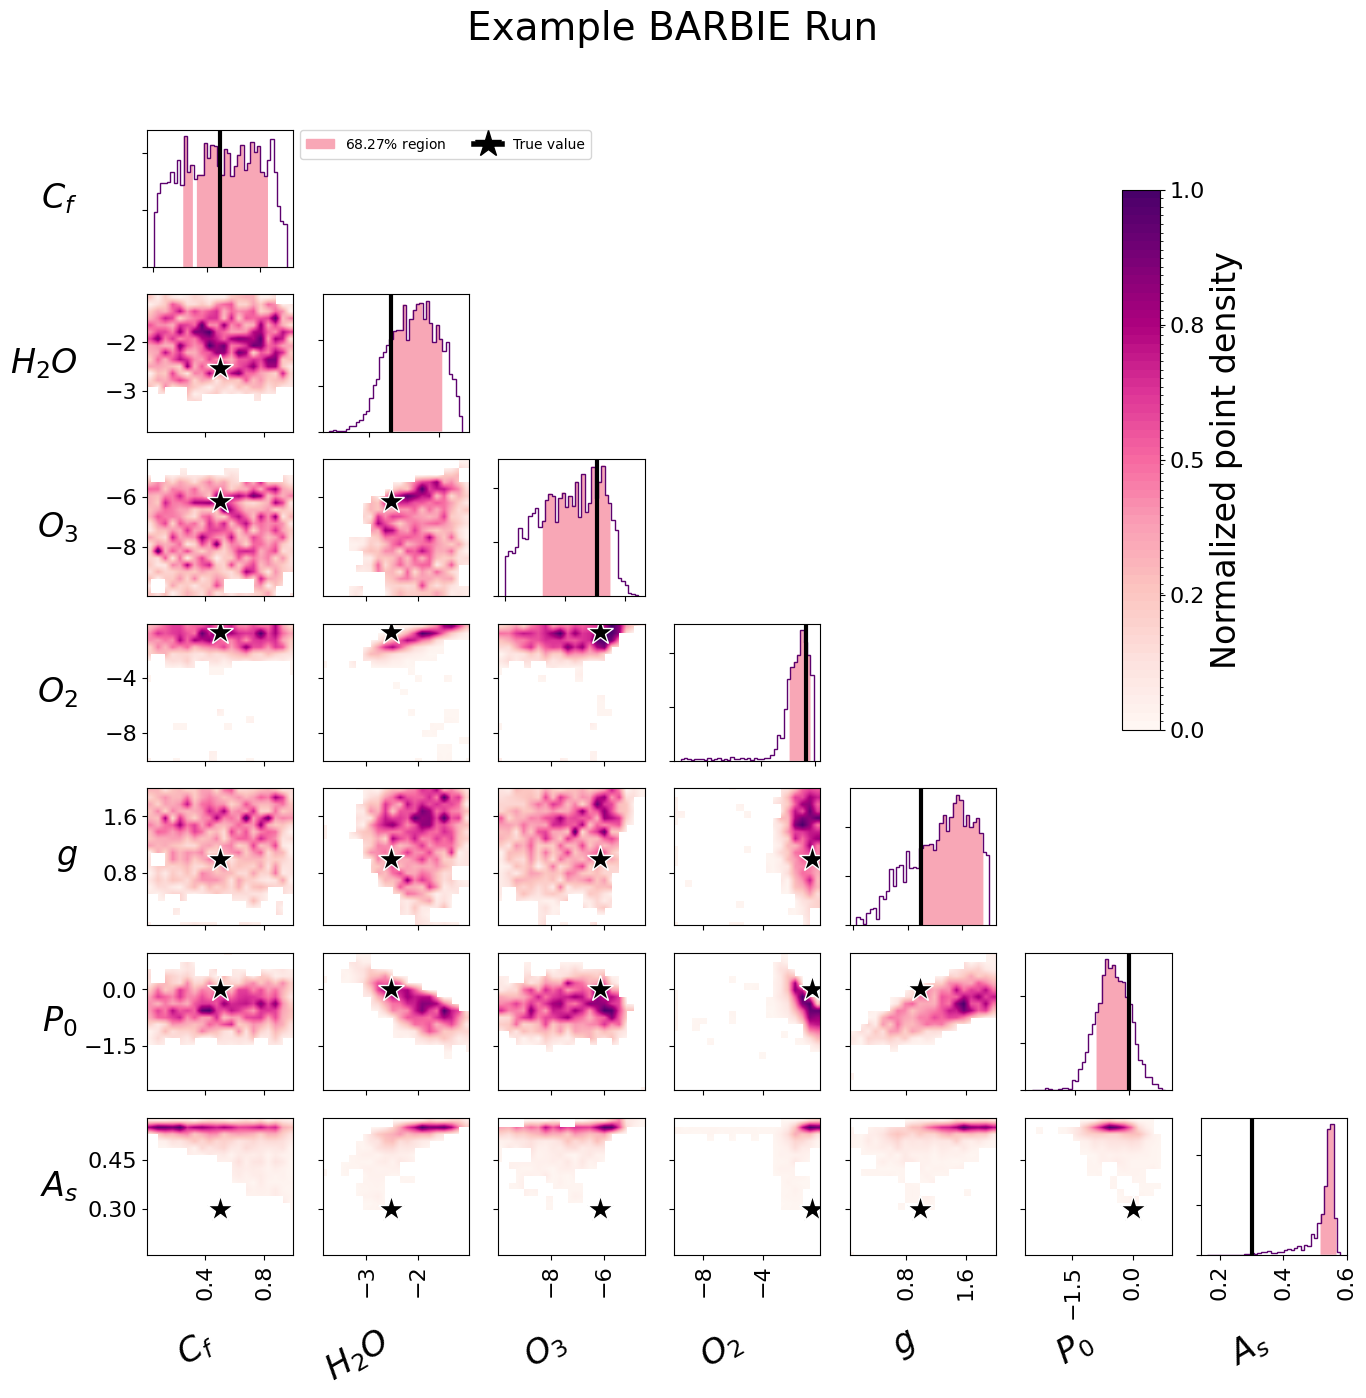

In [8]:
full_post1 = np.loadtxt(f"post.txt")
fullpost1 = np.transpose(full_post1)

H2O = 3e-3
P0 = 1.0
O3 = 7e-7
O2 = 0.21
g = 9.8
As = 0.3
Rp = 1.0

true_vals = [0.5, np.log10(H2O), np.log10(O3), np.log10(O2), np.log10(g), np.log10(P0), As]

figure1 = pairwise(fullpost1, title='Example BARBIE Run', parname=["$C_f$", "$H_2O$", "$O_3$", "$O_2$", "$g$", "$P_0$", "$A_s$"], thinning=1,
             fignum=-11, style="hist", fs=24, nbins=20, truepars=true_vals, credreg=True, ptitle=False, ndec=None)

# Now, the BARBIE way!

Now, we're moving from examples directly to how the BARBIE methodology works. This is where corner plots start to look less nice, but give you more information, since we're retrieving on real data. We will go step by step through making configs, running the configs, and how we get the posteriors and evidences. In this section, it is a highly pared down version of all the analysis that goes into BARBIE, just to show the corner plots!

In [9]:
# First, set up all the global variables - there's a lot of moving parts with BARBIE, so setting them once allows us to generalize the rest of the code
# and make our lives a lot easier. 

R = 140
bw = 0.2
SNR = [20]

if R == 70:
    SNR = [val * (1.41) for val in SNR] 
elif R == 140:
    SNR = SNR

vary_param = 'h2o'
case = ['3e-3']
grid_name = 'Merman'
wavelength_min, wavelength_max = 0.5, 1.0
wavelength = f'{wavelength_min}_{wavelength_max}'

featureless_spectrum = 0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/clear_earth_featureless_{R}.txt")[:,1]+0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/cloudy_earth_featureless_{R}.txt")[:,1]
default_wl = np.loadtxt(f"../grid_based_retrievals/barbie_ken/clear_earth_featureless_{R}.txt")[:,0] 

mask = (default_wl >= wavelength_min) & (default_wl <= wavelength_max)

featureless_spectrum = featureless_spectrum[mask]
default_wl = default_wl[mask]

if grid_name == 'Merman':
    min_vals = [0,             1.0E-10,     1.0e-10,      1.0e-10,       1,      1.0e-1,     0.01,       0.1]
    max_vals = [1,              0.3,        1.0e-5,         1,          31.6,   1.0e1,          1,      12.0]
    var_names = ["Clouds", "Water[H2O]", "Ozone[O3]", "Oxygen[O2]", "Gravity", "Pressure", "Albedo", "Radius"]
    variable_names = [{'Clouds': 'cf', 'Water[H2O]': 'H2O', 'Ozone[O3]': 'O3', 'Oxygen[O2]': 'O2', 'Gravity': 'g', 'Pressure': 'P0', 'Albedo': 'As'}]
    variable_names2 = ['cloud_f', 'H2O', 'O3', 'O2', 'g', 'P0', 'As']

elif grid_name == 'Beach':
    min_vals = [0,          1.0e-10,       1.0e-10,          1.0e-10,              1,        1.0e-1,    0.01,      0.1]
    max_vals = [1,           0.3,          79.4,              1.0e-1,             31.6,      1.0e1,       1,       12.0]
    var_names = ["Clouds", "Water[H2O]", "Methane[CH4]", "Carbon Dioxide[CO2]", "Gravity", "Pressure", "Albedo", "Radius"]
    variable_names = [{'Clouds': 'cf', 'Water[H2O]': 'H2O', 'Methane[CH4]': 'CH4', 'Carbon Dioxide[CO2]': 'CO2', 'Gravity': 'g', 'Pressure': 'P0', 'Albedo': 'As'}]
    variable_names2 = ['cloud_f', 'H2O', 'CH4', 'CO2', 'g', 'P0', 'As']

elif grid_name == 'Lifeguard':
    min_vals = [0,          1.0e-10,       1.0e-10,          1.0e-10,              1,        1.0e-1,    0.01,      0.1]
    max_vals = [1,           0.3,          1.0e-1,              1,                  31.6,      1.0e1,       1,       12.0]
    var_names = ["Clouds", "Water[H2O]", "Carbon Dioxide[CO2]",  "Carbon Monoxide[CO]", "Gravity", "Pressure", "Albedo", "Radius"]
    variable_names = [{'Clouds': 'cf', 'Water[H2O]': 'H2O', 'Carbon Dioxide[CO2]': 'CO2', 'Carbon Monoxide[CO]': 'CO', 'Gravity': 'g', 'Pressure': 'P0', 'Albedo': 'As'}]
    variable_names2 = ['cloud_f', 'H2O', 'CO2', 'CO', 'g', 'P0', 'As']
    
elif grid_name == 'Allan':
    min_vals = [0,          1.0e-10,       1.0e-10,          1.0e-10,              1,        1.0e-1,    0.01,      0.1]
    max_vals = [1,           1.0e-2,          1,              1,             31.6,      1.0e1,       1,       12.0]
    var_names = ["Clouds", "Ozone[O3]", "Sulfer Dioxide[SO2]",  "Nitrous Oxide[N2O]", "Gravity", "Pressure", "Albedo", "Radius"]
    variable_names = [{'Clouds': 'cf', 'Ozone[O3]': 'O3', 'Sulfer Dioxide[SO2]': 'SO2', 'Nitrous Oxide[N2O]': 'N2O', 'Gravity': 'g', 'Pressure': 'P0', 'Albedo': 'As'}]
    variable_names2 = ['cloud_f', 'O3', 'SO2', 'N2O', 'g', 'P0', 'As']


### Base Config Maker

The following cell makes the base config for each abundance case to be tested. In this example, it's only one abundance case. For BARBIE, it's generally 6-7 abundance cases. 

In [10]:
# Use this cell to make the fiducial rad files from the base clear_earth and cloudy_earth configs. You need to do this once for every abundance case run!

# Clear
server = 'https://psg.gsfc.nasa.gov/'
f = open(f"../Data/bp_cfgs/clear_earth_edit_{grid_name}.cfg", "r"); cfg = f.readlines(); f.close()

#<ATMOSPHERE-GAS>H2O,O3,O2,N2,CO2,CO,CH4,SO2,N2O
# For Merman Grid: H2O, O3, O2, N2
# For Beach Grid: H2O, CO2, CH4, N2
# For Allan Grid: N2, O3, SO2, N2O
# For Lifeguard Grid: H2O, N2, CO2, CO

abun_name = ['3e-3']
abun_vmr = ['3e-3']

abun = [val * (10**6) for val in abun_vmr]

for j,i in zip(abun_name, abun):
    file = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs/clear_earth_{j}.cfg' 
    if not os.path.exists(f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs'): 
        os.makedirs(f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs') # This is only necessary once, to create the directory
    cfg[0] = f'<ATMOSPHERE-ABUN>{i},1,1,1,\n' 
    cfg[1] = '<ATMOSPHERE-UNIT>ppm,scl,scl,scl,\n'  # This edits the config file created in line 10 of this cell
    cfg[2] = f'<GENERATOR-RESOLUTION>{R}\n'
    f = open(file, "w") # This opens the file, and the 'w' means to write
    for line in cfg: f.write(line) # This command actually writes in the value to the config, and the line below closes it
    f.close()
    file1 = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/clear_earth_{j}.txt'
    os.system(f"curl --data-urlencode file@{file} https://psg.gsfc.nasa.gov/api.php > {file1}")
    #os.system(f"curl --data-urlencode file@{file} http://localhost:3000/api.php > {file1}")

  
# Cloudy
f = open(f"../Data/bp_cfgs/cloudy_earth_edit_{grid_name}.cfg", "r"); cfg = f.readlines(); f.close()

for j,i in zip(abun_name, abun):
    file = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs/cloudy_earth_{j}.cfg' 
    if not os.path.exists(f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs'): 
        os.makedirs(f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/configs') # This is only necessary once, to create the directory
    cfg[0] = f'<ATMOSPHERE-ABUN>{i},1,1,1,\n' 
    cfg[1] = '<ATMOSPHERE-UNIT>ppm,scl,scl,scl,\n'  # This edits the config file created in line 10 of this cell
    cfg[2] = f'<GENERATOR-RESOLUTION>{R}\n'
    f = open(file, "w") # This opens the file, and the 'w' means to write
    for line in cfg: f.write(line) # This command actually writes in the value to the config, and the line below closes it
    f.close()
    file1 = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}/cloudy_earth_{j}.txt'
    os.system(f"curl -d key=ec8c307adc7c89612779 -d type=rad --data-urlencode file@{file} https://psg.gsfc.nasa.gov/api.php > {file1}")
    #os.system(f"curl --data-urlencode file@{file} http://localhost:3000/api.php > {file1}")

        # Rename the directories from R_140 to R=140
old_dir = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R_{R}'
new_dir = f'../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}'
if os.path.exists(old_dir):
    os.rename(old_dir, new_dir)
else:
    print(f"Directory {old_dir} does not exist.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3941k    0 23116  100 3918k   5624   953k  0:00:04  0:00:04 --:--:--  958k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3941k    0 23116  100 3918k   5286   896k  0:00:04  0:00:04 --:--:--  901k


### Config Maker for Gridrunner Submission

This set of cells defines the function to make PSGnest configuration files, and prepares them in the wanted file structure for submission to Gridrunner. Gridrunner has multiple workers, each with a PSG docker instance, and thus can run multiple retrievals simultaneously. For our purposes, it will make the configs to show as an example, but there will be a set of cells to individually run one config and make the results. 

In [11]:
def PSGnest_config(data_spectrum, sigma, wl_array, grid_name, add_noise, complexity="complex"):
    # Create a modified copy of the 'truths' list to adjust values if needed
    modified_truths = truths[:]

    # Check the 'complexity' parameter to determine the variable handling
    if complexity == "complex":
        # If complexity is "complex", use a default string of variable types for the config
        var_string = "linear,log,log,log,log,log,linear,fixed"
    else:
        # If complexity is not "complex", modify the corresponding variable to be "fixed"
        var_string = "linear,log,log,log,log,log,linear,fixed"
        var_string = var_string.split(",")  # Split the string into a list
        var_string[complexity] = "fixed"  # Set the complexity index to "fixed"
        var_string = ",".join(var_string)  # Join the list back into a string
        
        # Modify the truth values at the complexity index with the corresponding minimum value
        modified_truths[complexity] = min_vals[complexity]

    # Open the template configuration file for reading
    template = open("../PSGnest_template_cfg.txt", "r")
    # Create a new configuration file where the modified config will be written
    config = open("PSGnest_config.txt", "w")

    # Iterate through each line in the template file
    for line in template.readlines():
        # Replace retrieval variables and values when the relevant tag is encountered
        if "<RETRIEVAL-VARIABLES>" in line:
            # Write the modified truth values to the config file
            config.write(f"<RETRIEVAL-VALUES>{modified_truths[0]},{modified_truths[1]},{modified_truths[2]},{modified_truths[3]},{modified_truths[4]},{modified_truths[5]},{modified_truths[6]},{modified_truths[7]}\n")
            # Replace the variable names with the ones in var_names and write the modified line
            modified_line = line.replace("<RETRIEVAL-VARIABLES>Clouds,Water[H2O],Ozone[O3],Oxygen[O2],Gravity,Pressure,Albedo,Radius", f"<RETRIEVAL-VARIABLES>{var_names[0]},{var_names[1]},{var_names[2]},{var_names[3]},{var_names[4]},{var_names[5]},{var_names[6]},{var_names[7]}")
            config.write(modified_line)
        
        # Replace minimum retrieval values when the relevant tag is encountered
        elif "<RETRIEVAL-MIN>" in line:
            # Write the modified minimum values to the config file
            modified_line = line.replace("<RETRIEVAL-MIN>0,1.0E-8,1.0E-10,1.0E-10,1,1e-3,0.01,0.1", f"<RETRIEVAL-MIN>{min_vals[0]},{min_vals[1]},{min_vals[2]},{min_vals[3]},{min_vals[4]},{min_vals[5]},{min_vals[6]},{min_vals[7]}")
            config.write(modified_line)
        
        # Replace maximum retrieval values when the relevant tag is encountered
        elif "<RETRIEVAL-MAX>" in line:
            # Write the modified maximum values to the config file
            modified_line = line.replace("<RETRIEVAL-MAX>1,0.1,0.1,0.8,100,10,1,12.0", f"<RETRIEVAL-MAX>{max_vals[0]},{max_vals[1]},{max_vals[2]},{max_vals[3]},{max_vals[4]},{max_vals[5]},{max_vals[6]},{max_vals[7]}")
            config.write(modified_line)
        
        # Replace grid and nest details when the relevant tag is encountered
        elif "<RETRIEVAL-NEST>" in line:
            # Write the variable types (var_string) to the config file
            config.write(f"<RETRIEVAL-UNITS>{var_string}\n")
            # Modify the grid name and write the updated nest information
            modified_line = line.replace("<RETRIEVAL-NEST>Terrestrial,400", f"<RETRIEVAL-NEST>{grid_name},400")
            config.write(modified_line)
        
        # Append the data spectrum, wavelength, and sigma values under the <DATA> tag
        elif "<DATA>" in line:
            config.write(line)
            for i in range(len(wl_array)):
                # Write each wavelength, data spectrum value, and sigma value to the config file
                config.write(str(wl_array[i]) + " " + str(data_spectrum[i]) + " " + str(sigma))
                config.write("\n")
        
        # For all other lines, write them as they are
        else:
            config.write(line)

    # Close both template and config files
    template.close()
    config.close()
    
    # Copy the newly created configuration file to the main folder
    shutil.copyfile("./PSGnest_config.txt", main_folder_name + "PSGnest_config.txt")

In [12]:
# Loop over each case value (corresponding to H2O or CH4, depending on the grid_name)
for j in case:
    # Loop over each SNR value
    for n in SNR:
        # Define the atmospheric parameters based on the grid_name
        if grid_name == 'Merman':
            # Set parameters for the 'Merman' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = float(j) #float(j)  # Water abundance from the current case value
            P0 = 1.0  # Surface pressure
            O3 = 7e-7  # Ozone abundance
            O2 = 0.21  # Oxygen abundance
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, O3, O2, g, P0, As, Rp]
        
        elif grid_name == 'Beach':
            # Set parameters for the 'Beach' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = 3e-3  # Fixed water abundance
            P0 = 1.0  # Surface pressure
            CO2 = 3.8e-4  # Carbon dioxide abundance
            CH4 = float(j)  # Methane abundance from the current case value
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, CH4, CO2, g, P0, As, Rp]

        elif grid_name == 'Lifeguard':
            # Set parameters for the 'Lifeguard' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = 3e-3  # Fixed water abundance
            P0 = 1.0  # Surface pressure
            CO2 = 3.8e-4  # Carbon dioxide abundance
            CO = 8.3e-8  # Carbon monoxide abundance 
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, CO2, CO, g, P0, As, Rp]

        elif grid_name == 'Allan':
            # Set parameters for the 'Methane' grid case
            cloud_f = 0.5  # Cloud fraction
            O3 = 7e-7  # Oxygen abundance
            P0 = 1.0  # Surface pressure
            SO2 = 6.57e-11  # Sulfure oxide abundance
            N2O = 2.94e-7  # Nitrous oxide abundance
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, O3, SO2, N2O, g, P0, As, Rp]

        # Load and average the spectra from both clear and cloudy atmosphere simulations
        data_spectrum = 0.5 * np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/clear_earth_{j}.txt")[:,1] + \
                        0.5 * np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/cloudy_earth_{j}.txt")[:,1]
        
        # Mask the data spectrum to focus only on specific wavelengths
        data_spectrum = data_spectrum[mask]

        # Define the range for the bandpass centers based on the wavelength limits and bandwidth
        min_bp2 = min(default_wl) / (1 - bw / 2)
        max_bp2 = max(default_wl) / (1 + bw / 2)
        # Create an array of 25 evenly spaced bandpass center values
        bp_centers = np.linspace(min_bp2, max_bp2, 25)
        new_bp_centers = []  # Empty list to potentially store modified bandpass centers

        # List of variable indices to loop through (0 to 6, for different atmospheric variables)
        variables = [0,1,2,3,4,5,6]
        
        # Loop over each bandpass center
        for i in range(len(bp_centers)):
            if bw == bw:  # Check if bandwidth is defined (this always evaluates to True)
                # Define the center wavelength and bandwidth
                center_wl = bp_centers[i]
                bp_width = center_wl * bw
                # Calculate the lower and upper limits for the bandpass
                lower_limit = center_wl - bp_width / 2
                upper_limit = center_wl + bp_width / 2

                # Select the subset of wavelengths for this bandpass center
                luvex_wl = default_wl[np.argmin(abs(default_wl - bp_centers[i] * (1 - bw / 2))):np.argmin(abs(default_wl - bp_centers[i] * (1 + bw / 2)))]
                # Select the corresponding data spectrum values for this bandpass center
                luvex_spectrum = data_spectrum[np.argmin(abs(default_wl - bp_centers[i] * (1 - bw / 2))):np.argmin(abs(default_wl - bp_centers[i] * (1 + bw / 2)))]
                # Select the featureless spectrum for error estimation
                featureless_spectrum_subset = featureless_spectrum[np.argmin(abs(default_wl - bp_centers[i] * (1 - bw / 2))):np.argmin(abs(default_wl - bp_centers[i] * (1 + bw / 2)))]
                
                # Estimate the noise sigma as the mean value of the featureless spectrum subset divided by SNR
                sigma = np.mean(featureless_spectrum_subset) / n

                # Define the main folder path for saving results based on the current case, SNR, and bandpass
                main_folder_name = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/configs/{j}/SNR={n}/bandwidth={bw}/earth/{round(luvex_wl[0],3)}-{round(luvex_wl[-1],3)}/"
                # Create the folder if it doesn't already exist
                if not os.path.exists(main_folder_name):
                    os.makedirs(main_folder_name)
                
                # Call PSGnest_config to generate the configuration for this bandpass, with no added noise
                PSGnest_config(luvex_spectrum, sigma, luvex_wl, grid_name, add_noise=False)

                # Loop over the atmospheric variables for retrieval sensitivity tests
                for k in variables:
                    # Define a new folder path for each variable where a null test will be conducted
                    main_folder_name = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/configs/{j}/SNR={n}/bandwidth={bw}/earth/{round(luvex_wl[0],3)}-{round(luvex_wl[-1],3)}/null_{var_names[k]}/"
                    # Create the folder if it doesn't already exist
                    if not os.path.exists(main_folder_name):
                        os.makedirs(main_folder_name)
                    
                    # Call PSGnest_config for the null test with the given variable 'k' set to fixed
                    PSGnest_config(luvex_spectrum, sigma, luvex_wl, grid_name, add_noise=False, complexity=k)

### Pull in Results and Make Posteriors & Evidences

Okay, so above makes the configs, and then you go and submit through gridrunner, and THEN com back and continue in order to pull the posteriors and evidences from the results. NOTE: The results files are labelled as PSGnest_config.txt.txt - the double txt is what seperates it as a results file!

In [13]:
for j in case:
    for n in SNR:
        # Define source and destination paths
        main_folder_name2 = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/results/input/{case}/SNR={n}/bandwidth={bw}"
        main_folder_name3 = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/{case}/SNR={n}/bandwidth={bw}"
        
        # Ensure destination directory exists without nesting issues
        os.makedirs(os.path.dirname(main_folder_name3), exist_ok=True)
        
        #check if the source folder exists
        if os.path.exists(main_folder_name2):
            # Move the folder from input to final location
            shutil.move(main_folder_name2, main_folder_name3)
        else:
            continue

In [14]:
def PSGnest_results(data_spectrum, sigma, wl_array, add_noise, complexity="complex"):

    # Define file paths for posteriors and evidences
    post_file_name = main_folder_name + f"post.txt"
    evidence_file_name = main_folder_name + f"evidence.txt"
    
    # Remove existing posterior and evidence files if they exist
    if os.path.exists(post_file_name):
        os.remove(post_file_name)
    if os.path.exists(evidence_file_name):
        os.remove(evidence_file_name)
    
    evidences = []  # List to store evidence values
    loglikes = []  # List to store log-likelihood values

    # Define the variable string based on the complexity (fixed vs complex retrieval)
    if complexity == "complex":
        var_string = "linear,log,log,log,log,log,linear,fixed"
    else:
        # Start with the same string, then fix the variable corresponding to 'complexity'
        var_string = "linear,log,log,log,log,log,linear,fixed"
        var_string = var_string.split(",")
        var_string[complexity] = "fixed"  # Fix the specified variable
        var_string = ",".join(var_string)

        # Modify the true values for the retrieval by fixing the variable at min_vals[complexity]
        modified_truths = truths[:]
        modified_truths[complexity] = min_vals[complexity]

    # If the PSGnest config file exists, rename it to PSGnest_results.txt
    if os.path.exists(main_folder_name + 'PSGnest_config.txt.txt'):
        os.rename(main_folder_name + "PSGnest_config.txt.txt", main_folder_name + "PSGnest_results.txt")

    # Open the PSGnest results file for reading
    result = open(main_folder_name + "PSGnest_results.txt", "r")
    
    # Initialize variables for parsing the results
    spectrum_start = 0
    posterior_start = 0
    posterior_end = 0

    best_fit_spectrum = []  # List to store the best-fit spectrum
    posteriors = []  # List to store posterior samples

    line_index = 1
    spectrum_retrieved = False
    posterior_retrieved = False

    # Loop through each line of the PSGnest results file
    for line in result.readlines():

        # Check for keywords indicating the start of the spectrum or posterior sections
        if "results_dat" in line:
            spectrum_start = line_index
        if "results_nst" in line:
            posterior_start = line_index
        if "Computation time" in line:
            posterior_end = line_index

        line_index += 1

        # Retrieve the best-fit spectrum data between spectrum_start and posterior_start
        if spectrum_start != 0 and posterior_start != 0 and not spectrum_retrieved:
            result2 = open(main_folder_name + "PSGnest_results.txt", "r")
            for line2 in result2.readlines()[spectrum_start:posterior_start - 1]:
                try:
                    best_fit_spectrum.append(float(line2.split()[-1]))  # Append spectrum value
                except ValueError:
                    continue  # Skip lines that don't contain valid floats
            result2.close()
            spectrum_retrieved = True

        # Retrieve posterior samples and log-likelihood values
        if posterior_start != 0 and posterior_end != 0 and not posterior_retrieved:
            result2 = open(main_folder_name + "PSGnest_results.txt", "r")
            for line2 in result2.readlines()[posterior_start:posterior_end - 1]:
                posterior_sample = [float(i) for i in line2.split()[:-1]]  # Parse the posterior sample
                posteriors.append(posterior_sample)
                loglike = float(line2.split()[-1])  # Extract log-likelihood value
                loglikes.append(loglike)
            result2.close()
            posterior_retrieved = True

        # If the line contains the log-evidence, save it in the evidence file
        if "Nested Sampling Global Log-Evidence" in line:
            with open(evidence_file_name, "w") as f:  # Overwrite the evidence file
                f.write(line.split()[-1])  # Write the log-evidence value

    result.close()

    # Convert the posteriors list to a NumPy array
    posteriors = np.array(posteriors)

    # Write the posterior samples to the post.txt file
    with open(post_file_name, "w") as f:
        for i in posteriors:
            # Write different numbers of posterior parameters depending on the complexity level
            if complexity != "complex":
                f.write(str(i[0])+" "+str(i[1])+" "+str(i[2])+" "+str(i[3])+" "+str(i[4])+" "+str(i[5])+" "+"\n")
            else:
                f.write(str(i[0])+" "+str(i[1])+" "+str(i[2])+" "+str(i[3])+" "+str(i[4])+" "+str(i[5])+" "+str(i[6])+" "+"\n")


In [16]:
for j in case:
    for n in SNR:
        if grid_name == 'Merman':
            # Set parameters for the 'Merman' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = 3e-3 #float(j)  # Water abundance from the current case value
            P0 = 1.0  # Surface pressure
            O3 = 7e-7  # Ozone abundance
            O2 = 0.21  # Oxygen abundance
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, O3, O2, g, P0, As, Rp]
        
        elif grid_name == 'Beach':
            # Set parameters for the 'Beach' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = 3e-3  # Fixed water abundance
            P0 = 1.0  # Surface pressure
            CO2 = 3.8e-4  # Carbon dioxide abundance
            CH4 = float(j)  # Methane abundance from the current case value
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, CH4, CO2, g, P0, As, Rp]

        elif grid_name == 'Lifeguard':
            # Set parameters for the 'Lifeguard' grid case
            cloud_f = 0.5  # Cloud fraction
            H2O = 3e-3  # Fixed water abundance
            P0 = 1.0  # Surface pressure
            CO2 = 3.8e-4  # Carbon dioxide abundance
            CO = 8.3e-8  # Carbon monoxide abundance 
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, H2O, CO2, CO, g, P0, As, Rp]

        elif grid_name == 'Allan':
            # Set parameters for the 'Methane' grid case
            cloud_f = 0.5  # Cloud fraction
            O3 = 7e-7  # Oxygen abundance
            P0 = 1.0  # Surface pressure
            SO2 = 6.57e-11  # Sulfure oxide abundance
            N2O = 2.94e-7  # Nitrous oxide abundance
            g = 9.8  # Gravitational acceleration
            As = 0.3  # Surface albedo
            Rp = 1.0  # Planetary radius
            # List of true values for the parameters (used for retrieval)
            truths = [cloud_f, O3, SO2, N2O, g, P0, As, Rp]
        
        # Load and combine the spectra from clear and cloudy atmospheres
        data_spectrum = 0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/clear_earth_{j}.txt")[:,1]+0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/cloudy_earth_{j}.txt")[:,1]
        data_spectrum = data_spectrum[mask]  # Apply mask to data spectrum

        # Calculate minimum and maximum bandpass centers based on the wavelength range and bandpass width (bw)
        min_bp2 = min(default_wl)/(1-bw/2)  # Calculate the minimum bandpass center
        max_bp2 = max(default_wl)/(1+bw/2)  # Calculate the maximum bandpass center
        bp_centers = np.linspace(min_bp2, max_bp2, 25)  # Create 25 evenly spaced bandpass centers
        
        variables = [0,1,2,3,4,5,6]  # List of variables for which retrievals are performed
        
        # Loop through the bandpass centers and calculate corresponding spectra and sigma values
        for i in range(len(bp_centers)):
            if bw == bw:  # Check for valid bandpass width
                
                # Calculate center wavelength, bandpass width, and limits
                center_wl = bp_centers[i]
                bp_width = center_wl * bw
                lower_limit = center_wl - bp_width/2
                upper_limit = center_wl + bp_width/2
                        
                # Extract the wavelength and spectrum for the current bandpass
                luvex_wl = default_wl[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
                luvex_spectrum = data_spectrum[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
                featureless_spectrum_subset = featureless_spectrum[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
                
                sigma = np.mean(featureless_spectrum_subset)/n  # Calculate noise level (sigma)
                
                # Define the main folder name for saving results
                main_folder_name = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/{j}/SNR={n}/bandwidth={bw}/earth/{round(luvex_wl[0],3)}-{round(luvex_wl[-1],3)}/"                
                if not os.path.exists(main_folder_name):  # Create the directory if it doesn't exist
                    os.makedirs(main_folder_name)
                
                # Call the PSGnest_results function for the main spectrum
                PSGnest_results(luvex_spectrum, sigma, luvex_wl, add_noise=False)
                
                # Loop through variables for null hypothesis retrievals and save results in separate folders
                for k in variables:
                    main_folder_name = f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/{j}/SNR={n}/bandwidth={bw}/earth/{round(luvex_wl[0],3)}-{round(luvex_wl[-1],3)}/null_{var_names[k]}/"
                    if not os.path.exists(main_folder_name):  # Create directory if it doesn't exist
                        os.makedirs(main_folder_name)
                    
                    # Call the PSGnest_results function for each null hypothesis retrieval
                    PSGnest_results(luvex_spectrum, sigma, luvex_wl, add_noise=False, complexity=k)


## Finally, make a corner plot again, with our new results!

In [19]:
for j in case:
    # data_spectrum = 0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/no_water/clear_earth_{j}.txt")[:,1]+0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/no_water/cloudy_earth_{j}.txt")[:,1]
    data_spectrum = 0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/clear_earth_{j}.txt")[:,1]+0.5*np.loadtxt(f"../grid_based_retrievals/barbie_ken/{vary_param}_test/R={R}/cloudy_earth_{j}.txt")[:,1]
    data_spectrum = data_spectrum[mask]
    
    min_bp2 = min(default_wl)/(1-bw/2) # x*(1-bw/2)>0.54957594
    max_bp2 = max(default_wl)/(1+bw/2) # x*(1+bw/2)<0.99879521
    bp_centers = np.linspace(min_bp2, max_bp2, 25)
    new_bp_centers = []
    
    luvex_wls = []
    luvex_spectra = []
    featureless_spectra = []
    
    lower = []
    upper = []
    
    
    for i in range(len(bp_centers)):
        if bw == bw:
            center_wl = bp_centers[i]
            bp_width = center_wl * bw
            lower_limit = center_wl - bp_width/2
            upper_limit = center_wl + bp_width/2
            
            luvex_wl = default_wl[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
            luvex_spectrum = data_spectrum[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
            featureless_spectrum_subset = featureless_spectrum[np.argmin(abs(default_wl-bp_centers[i] * (1-bw/2))):np.argmin(abs(default_wl-bp_centers[i] * (1+bw/2)))]
            
            luvex_wl_lower = round(luvex_wl[0], 3)
            luvex_wl_upper = round(luvex_wl[-1], 3)
            
            lower.append(luvex_wl_lower)
            upper.append(luvex_wl_upper)
            
            luvex_wl_lower_idx = np.argmin(abs(default_wl - luvex_wl_lower))
            luvex_wl_upper_idx = np.argmin(abs(default_wl - luvex_wl_upper))
            new_bp_center = np.mean(default_wl[luvex_wl_lower_idx:luvex_wl_upper_idx])
            new_bp_centers.append(new_bp_center)
        
luvex_wls.append(luvex_wl)
luvex_spectra.append(luvex_spectrum)
featureless_spectra.append(featureless_spectrum_subset)
bp_centers = new_bp_centers
lower = lower
upper = upper

data = list(zip(lower, upper, bp_centers))
headers = ["Lower", "Upper", "BP_Centers"]

table = tabulate(data, headers=headers, tablefmt="pretty")

print(table)
#print(bp_centers)

+-------+-------+--------------------+
| Lower | Upper |     BP_Centers     |
+-------+-------+--------------------+
| 0.501 | 0.607 | 0.5503387253814815 |
| 0.515 | 0.625 | 0.5662319636777778 |
| 0.527 | 0.638 | 0.5784523802666667 |
| 0.542 | 0.657 | 0.5951575131222222 |
| 0.553 | 0.671 | 0.6080022008333332 |
| 0.565 | 0.69  | 0.6234107784178572 |
| 0.582 | 0.705 | 0.6390615525703703 |
| 0.594 | 0.72  | 0.652853777137037  |
| 0.607 | 0.736 | 0.6669436654481481 |
| 0.62  | 0.752 | 0.6813376416925927 |
| 0.634 | 0.768 | 0.6960422686925926 |
| 0.647 | 0.784 | 0.7110642509074075 |
| 0.661 | 0.801 | 0.7264104374962962 |
| 0.671 | 0.819 | 0.7395374205499999 |
| 0.685 | 0.83  | 0.7527269417148147 |
|  0.7  | 0.848 | 0.768972292374074  |
| 0.71  | 0.867 | 0.7828684118857144 |
| 0.725 | 0.879 | 0.7968307337407409 |
| 0.741 | 0.898 | 0.814027932311111  |
| 0.752 | 0.911 | 0.8256984348074075 |
| 0.762 | 0.93  | 0.8406196539964286 |
| 0.779 | 0.944 |    0.8556119592    |
| 0.79  | 0.957 | 0.86787

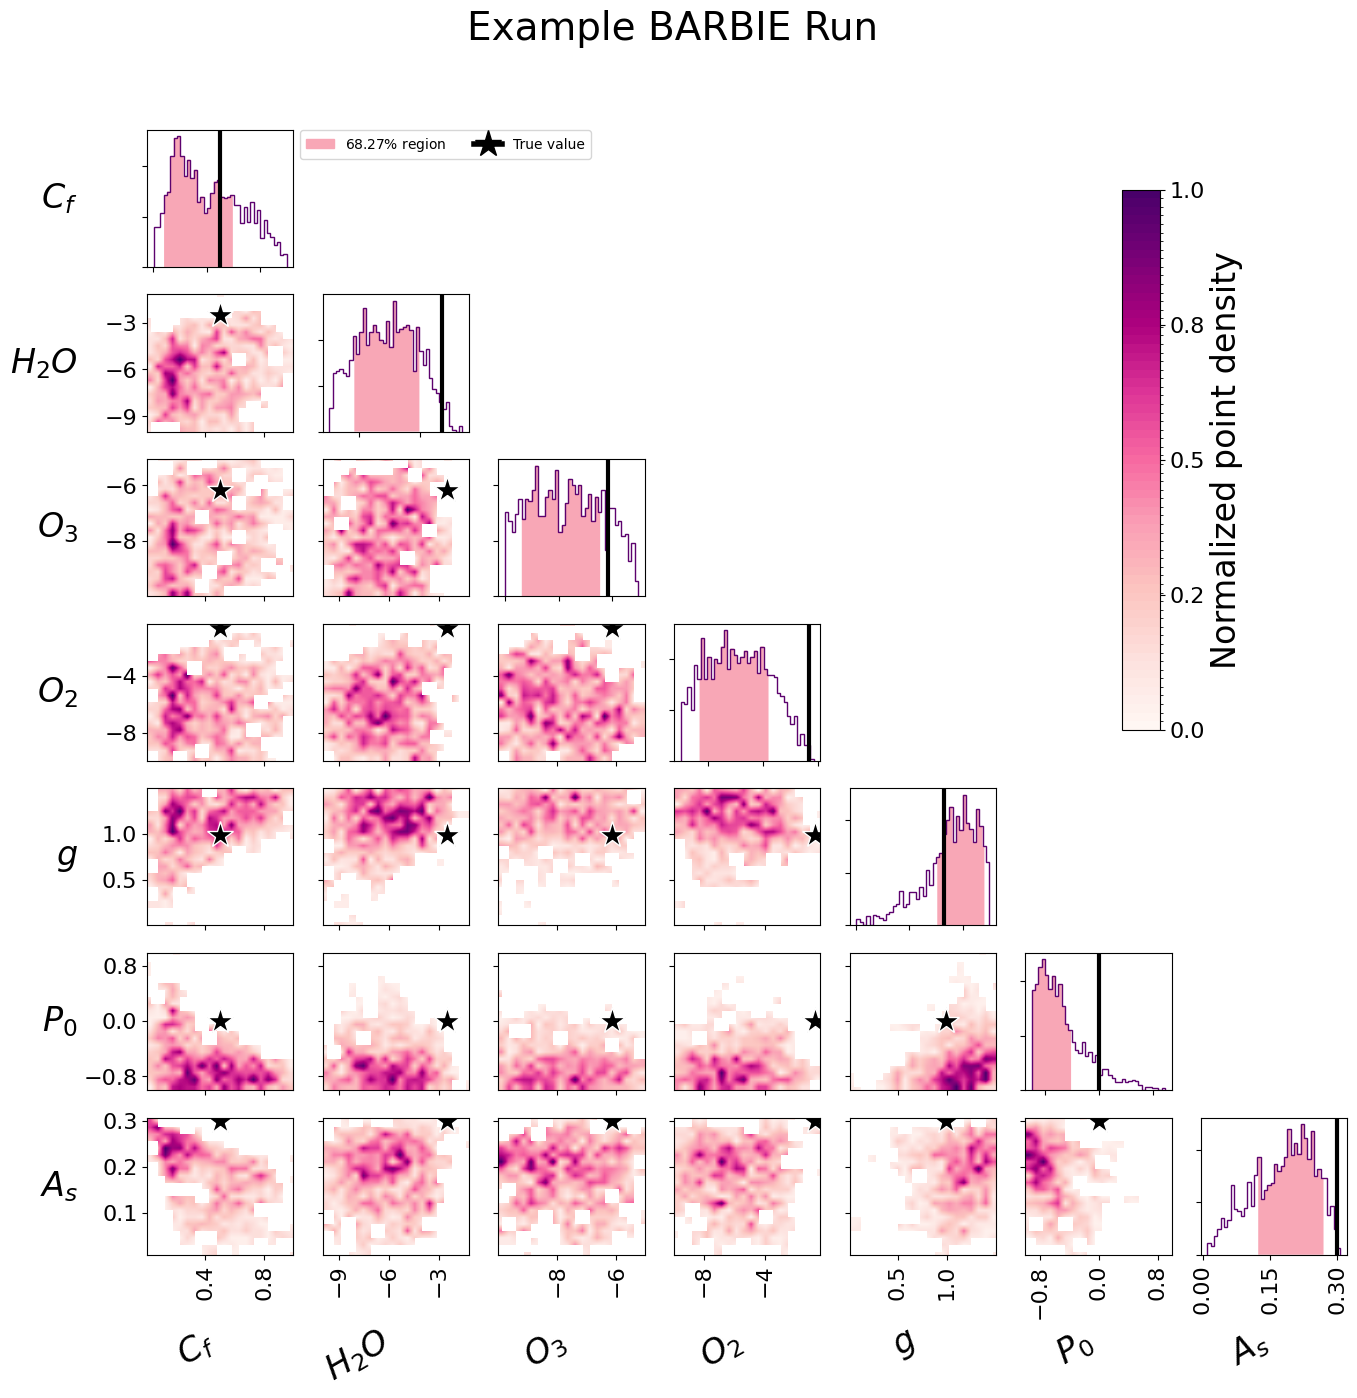

In [22]:
full_post1 = np.loadtxt(f"./retrieval_workshop_test/{vary_param}_test/R={R}/{wavelength}_wl/{j}/SNR={n}/bandwidth={bw}/earth/0.7-0.848/post.txt")
fullpost1 = np.transpose(full_post1)

H2O = 3e-3
P0 = 1.0
O3 = 7e-7
O2 = 0.21
g = 9.8
As = 0.3
Rp = 1.0

true_vals = [0.5, np.log10(H2O), np.log10(O3), np.log10(O2), np.log10(g), np.log10(P0), As]

figure1 = pairwise(fullpost1, title='Example BARBIE Run', parname=["$C_f$", "$H_2O$", "$O_3$", "$O_2$", "$g$", "$P_0$", "$A_s$"], thinning=1,
             fignum=-11, style="hist", fs=24, nbins=20, truepars=true_vals, credreg=True, ptitle=False, ndec=None)